# Intercellular distance analysis (experimental)

> 🎯 **Goal**: Explore Carlos' intercellular distance data.
>
> ☑️ **Status**: Under development 🚧

---


## Read the data

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
from scipy import stats

Carlos' data includes more conditions than we analyzed with the computational study, so we will be selecting the conditions we have studied.

In [3]:
dist_df = pd.read_csv("distances-data/pdgf-neighborhood.csv",
                      header=None, names=['condition', 'neighborhood', 'value'])

for condition in dist_df['condition'].unique():
    print(condition)

'haptotaxis-2_5mgml-144h-2ch'
'haptotaxis-2_5mgml-144h-mono'
'haptotaxis-2_5mgml-144h-control'
'haptotaxis-2_5mgml-216h-opch'
'haptotaxis-2_5mgml-216h-control'
'quimiotaxis-1canal-2_5mgml-96h-mono'
'quimiotaxis-1canal-2_5mgml-96h-op'
'quimiotaxis-1canal-2_5mgml-96h-control'
'quimiotaxis-2_5mgml-3ch-216h-op'
'quimiotaxis-2_5mgml-3ch-216h'
'quimiotaxis-2_5-2-1_5mgml-312h-op'
'quimiotaxis-2_5-2-1_5mgml-312h-control'
'quimiotaxis-2_5mgml-TG2-96h-ch_mono'
'quimiotaxis-2_5mgml-TG2-96h-control'
'quimiotaxis-4mgml-96h-control'
'quimiotaxis-4mgml-96h-factor-op'


In particular, we will want to get every chemotaxis dataset, except for the ones that include TG2 and those that were obtained for a 1.5 mg/mL matrix.

In [4]:
# Getting data for the  computational conditions
chemotaxis_df = dist_df[dist_df['condition'].str.contains('quimiotaxis')]
chemotaxis_df = chemotaxis_df[~chemotaxis_df['condition'].str.contains('TG2')]
chemotaxis_df = chemotaxis_df[~chemotaxis_df['condition'].str.contains('1_5mgml')]

for condition in chemotaxis_df['condition'].unique():
    print(condition)

'quimiotaxis-1canal-2_5mgml-96h-mono'
'quimiotaxis-1canal-2_5mgml-96h-op'
'quimiotaxis-1canal-2_5mgml-96h-control'
'quimiotaxis-2_5mgml-3ch-216h-op'
'quimiotaxis-2_5mgml-3ch-216h'
'quimiotaxis-4mgml-96h-control'
'quimiotaxis-4mgml-96h-factor-op'


In [22]:
high_density_df = chemotaxis_df[chemotaxis_df['condition'].str.contains('4mgml')]

Now that we have the data, we can start analyzing it. 

## Number of neighbors

### General trends
Firstly, we will be looking at the effect of the number of neighbors for the 1 channel, 2.5 mg/mL study.

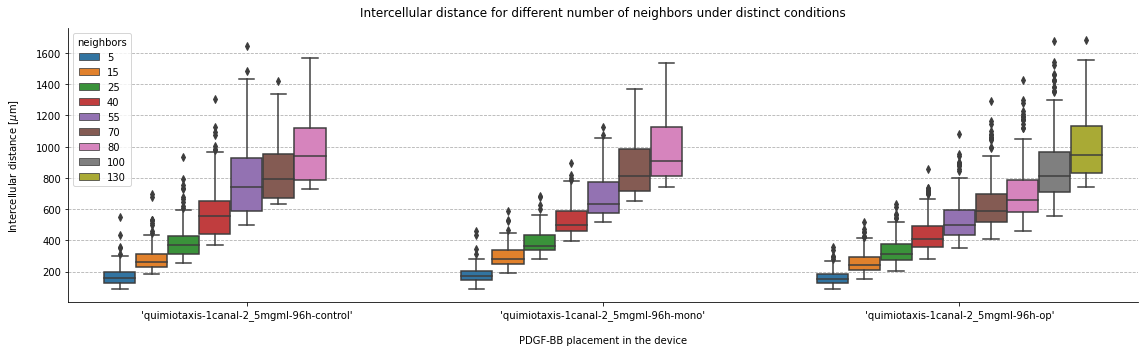

In [8]:
# Getting data for one channel, 2.5 mg/mL experiments
single_chamber = chemotaxis_df['condition'].str.contains('1canal')
single_df = chemotaxis_df[single_chamber]
conditions = ["'quimiotaxis-1canal-2_5mgml-96h-control'",
              "'quimiotaxis-1canal-2_5mgml-96h-mono'",
              "'quimiotaxis-1canal-2_5mgml-96h-op'"]

fig, ax = plt.subplots(figsize=(16, 5))
sns.boxplot(data=single_df[single_df['neighborhood'].isin([5, 15, 25, 40, 55, 70, 80, 100, 130])], 
            x='condition', y='value', 
            order = conditions,
            hue='neighborhood', ax=ax)

ax.legend(loc='upper left', title='neighbors')
ax.set_ylabel('Intercellular distance [$\mu$m]', labelpad=15)
ax.set_xlabel('PDGF-BB placement in the device', labelpad=15)
ax.set_title('Intercellular distance for different number of neighbors under distinct conditions', y=1.02)
ax.set_axisbelow(True)
ax.grid(axis='y', linestyle='--')
sns.despine()
plt.tight_layout()

Based on the previous plot, we can conclude two things:
- Up until 40 neighbors, the results for all three conditions seem to be similar (we will look into this to confirm it later on);
- For more than 40 neighbors, the results for the monolayer channel see to be consistent with those obtained under control conditions. Yet,the distance values for the opposite channel results seem to be smaller when directly compared to the results obtained for the same number of neighbors in the other conditions. 

In addition, the opposite channel results include more data for a larger number of neighbors (>100). Could this be due to cell proliferation? As cells proliferate they would be closer to each other (hence the smaller distances for the same number of neighbors), and there would be a larger number of cells.

We can look at a more comprehensive range of neighborhood values by plotting the median distance value over the number of neighbors.

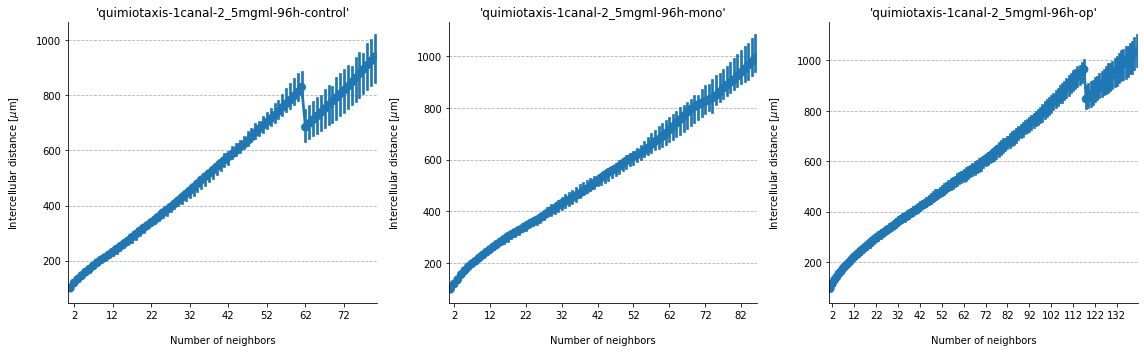

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for condition, ax in zip(conditions, axes):
    condition_df = single_df[single_df['condition'] == condition]
    sns.pointplot(data=condition_df, estimator=np.median,
                x='neighborhood', y='value', ax=ax)

    ax.set_ylabel('Intercellular distance [$\mu$m]', labelpad=15)
    ax.set_xlabel('Number of neighbors', labelpad=15)
    ax.set_title(condition)
    
    ax.set_xticks(range(condition_df['neighborhood'].min(), condition_df['neighborhood'].max(), 10))
    
    ax.set_axisbelow(True)
    ax.grid(axis='y', linestyle='--')
    
sns.despine()
plt.tight_layout()

I am  not quite sure what these results represent. It appears that the distance values are consistently increasing, which maybe means that there are no relevant clusters? But the sudden decrease seen for the control and opposite channel results is something I don't quite understand.

### Statistical differences

In [10]:
control_df = chemotaxis_df[single_chamber & chemotaxis_df['condition'].str.contains('control')]
mono_df = chemotaxis_df[single_chamber & chemotaxis_df['condition'].str.contains('mono')]
opp_df = chemotaxis_df[single_chamber & chemotaxis_df['condition'].str.contains('op')]

#### Statistical differences between neighbor numbers

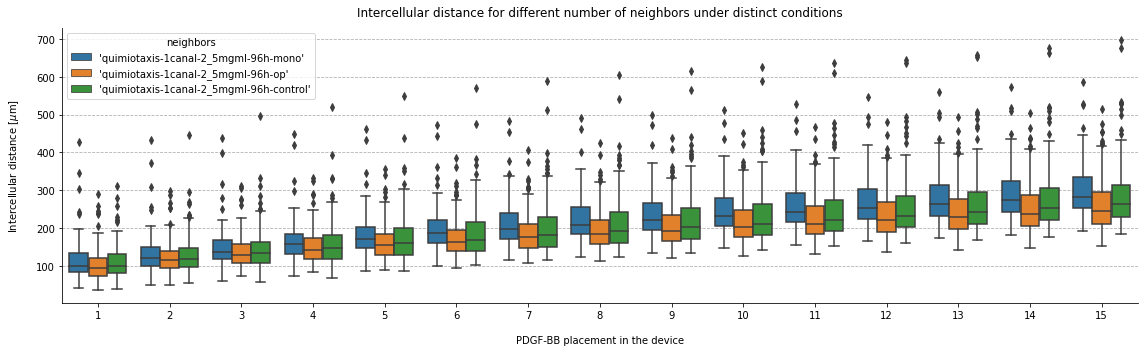

In [11]:
# Getting data for one channel, 2.5 mg/mL experiments
fig, ax = plt.subplots(figsize=(16, 5))
sns.boxplot(data=single_df[single_df['neighborhood'].between(1, 15)], 
            x='neighborhood', y='value', 
            hue='condition', ax=ax)

ax.legend(loc='upper left', title='neighbors')
ax.set_ylabel('Intercellular distance [$\mu$m]', labelpad=15)
ax.set_xlabel('PDGF-BB placement in the device', labelpad=15)
ax.set_title('Intercellular distance for different number of neighbors under distinct conditions', y=1.02)
ax.set_axisbelow(True)
ax.grid(axis='y', linestyle='--')
sns.despine()
plt.tight_layout()

In [12]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

p_thresh = 0.05

for neighbors in range(1, 7):
    data_control = control_df[control_df['neighborhood'] == neighbors]['value'].values
    data_mono = mono_df[mono_df['neighborhood'] == neighbors]['value'].values
    data_opp = opp_df[opp_df['neighborhood'] == neighbors]['value'].values

    fvalue, pvalue = stats.f_oneway(data_control, data_mono, data_opp)

    print(pvalue)

0.02589403626078274
0.07405308109194857
0.03187453329749018
0.005873544746601113
0.0013866395045649654
0.00045446372003196634


In [13]:
neighbor_data = single_df[single_df['neighborhood'] == 15]
tukey = pairwise_tukeyhsd(neighbor_data['value'], neighbor_data['condition'], alpha=p_thresh)
print(tukey)

                                  Multiple Comparison of Means - Tukey HSD, FWER=0.05                                  
                 group1                                  group2                meandiff p-adj   lower    upper   reject
-----------------------------------------------------------------------------------------------------------------------
'quimiotaxis-1canal-2_5mgml-96h-control' 'quimiotaxis-1canal-2_5mgml-96h-mono'  11.3536 0.5115 -12.7906  35.4977  False
'quimiotaxis-1canal-2_5mgml-96h-control'   'quimiotaxis-1canal-2_5mgml-96h-op' -29.9338  0.001 -48.4211 -11.4466   True
   'quimiotaxis-1canal-2_5mgml-96h-mono'   'quimiotaxis-1canal-2_5mgml-96h-op' -41.2874  0.001 -63.2809 -19.2939   True
-----------------------------------------------------------------------------------------------------------------------


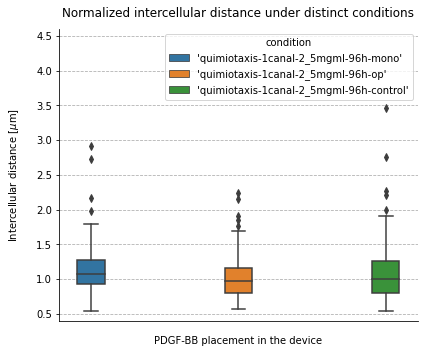

In [27]:
normalized_df = single_df.copy()

neighbors = 5
normalized_df = normalized_df[normalized_df['neighborhood'] == neighbors]
control_norm = normalized_df[normalized_df['condition'] == "'quimiotaxis-1canal-2_5mgml-96h-control'"]
normalization_value = np.median(control_norm['value'])

normalized_df['norm_value'] = normalized_df['value']/normalization_value

# Getting data for one channel, 2.5 mg/mL experiments
fig, ax = plt.subplots(figsize=(6, 5))
sns.boxplot(data=normalized_df, 
            x='condition', y='norm_value', 
            hue='condition', ax=ax, width=0.7)

ax.set_ylabel('Intercellular distance [$\mu$m]', labelpad=15)
ax.set_xlabel('PDGF-BB placement in the device', labelpad=15)
ax.set_title('Normalized intercellular distance under distinct conditions', y=1.02)
ax.set_xticks([])
ax.set_axisbelow(True)
ax.grid(axis='y', linestyle='--')
ax.set_ylim(0.4, 4.6)
sns.despine()
plt.tight_layout()
plt.savefig('norm-experimental-2.svg', format='svg')

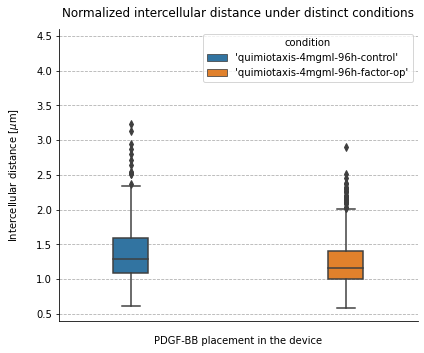

In [26]:
normalized_df = high_density_df.copy()

neighbors = 5
normalized_df = normalized_df[normalized_df['neighborhood'] == neighbors]

normalized_df['norm_value'] = normalized_df['value']/normalization_value

# Getting data for one channel, 2.5 mg/mL experiments
fig, ax = plt.subplots(figsize=(6, 5))
sns.boxplot(data=normalized_df, 
            x='condition', y='norm_value', 
            hue='condition', ax=ax, width=0.4)

ax.set_ylabel('Intercellular distance [$\mu$m]', labelpad=15)
ax.set_xlabel('PDGF-BB placement in the device', labelpad=15)
ax.set_title('Normalized intercellular distance under distinct conditions', y=1.02)
ax.set_xticks([])
ax.set_axisbelow(True)
ax.grid(axis='y', linestyle='--')
ax.set_ylim(0.4, 4.6)
sns.despine()
plt.tight_layout()
plt.savefig('norm-experimental-4.svg', format='svg')

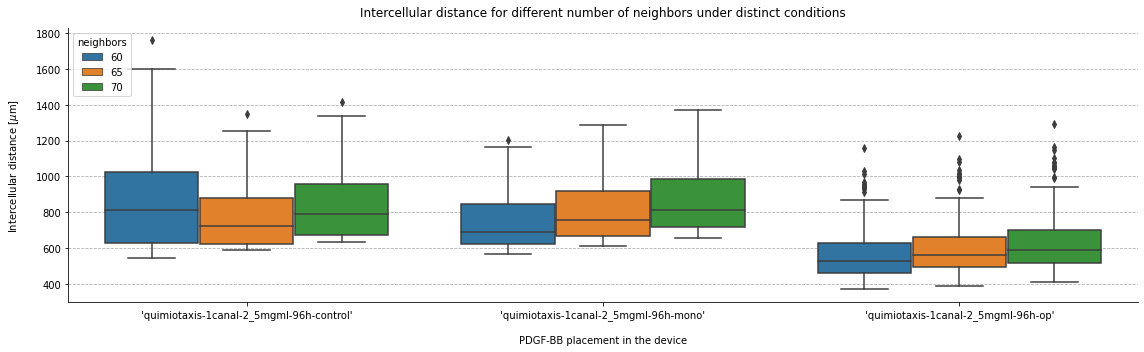

In [67]:
# Getting data for one channel, 2.5 mg/mL experiments
single_chamber = chemotaxis_df['condition'].str.contains('1canal')
single_df = chemotaxis_df[single_chamber]

fig, ax = plt.subplots(figsize=(16, 5))
sns.boxplot(data=single_df[single_df['neighborhood'].isin([60, 65, 70])], 
            x='condition', y='value', 
            order = ["'quimiotaxis-1canal-2_5mgml-96h-control'",
                     "'quimiotaxis-1canal-2_5mgml-96h-mono'",
                     "'quimiotaxis-1canal-2_5mgml-96h-op'"],
            hue='neighborhood', ax=ax)

ax.legend(loc='upper left', title='neighbors')
ax.set_ylabel('Intercellular distance [$\mu$m]', labelpad=15)
ax.set_xlabel('PDGF-BB placement in the device', labelpad=15)
ax.set_title('Intercellular distance for different number of neighbors under distinct conditions', y=1.02)
ax.set_axisbelow(True)
ax.grid(axis='y', linestyle='--')
sns.despine()
plt.tight_layout()

In [37]:
data_one = control_df[control_df['neighborhood'] == 5]['value']
data_two = mono_df[mono_df['neighborhood'] == 5]['value']

fvalue, pvalue = stats.f_oneway(data_one, data_two)

pvalue

0.23008933996153255

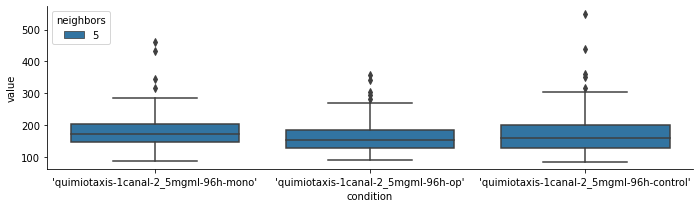

In [28]:
fig, ax = plt.subplots(figsize=(10, 3))
sns.boxplot(data=single_df[single_df['neighborhood'] == 5], 
            x='condition', y='value', hue='neighborhood', ax=ax)

ax.legend(loc='upper left', title='neighbors')
sns.despine()
plt.tight_layout()

In [116]:
# Getting data for three channels, 2.5 mg/mL experiments
three_chambers = chemotaxis_df['condition'].str.contains('3ch')
three_chambers_df = chemotaxis_df[three_chambers]
three_chambers_control_df = chemotaxis_df[three_chambers & ~chemotaxis_df['condition'].str.contains('op')]
three_chambers_factor_df = chemotaxis_df[three_chambers & chemotaxis_df['condition'].str.contains('op')]

In [117]:
from scipy import stats

stats.f_oneway(three_chambers_control_df[three_chambers_control_df['neighborhood'] == 10]['value'], 
               three_chambers_factor_df[three_chambers_factor_df['neighborhood'] == 10]['value'])

F_onewayResult(statistic=4.428178513876739, pvalue=0.03580675807199394)

<AxesSubplot:xlabel='condition', ylabel='value'>

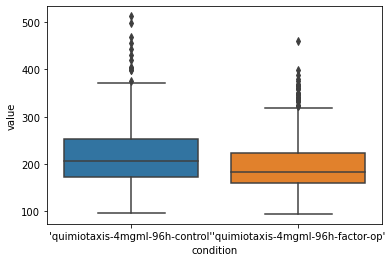

In [29]:
# Getting data for 4mg/mL experiments
high_density_df = dist_df[dist_df['condition'].str.contains('4mg')]
high_density_control_df = high_density_df[high_density_df['condition'].str.contains('control')]
high_density_factor_df = high_density_df[high_density_df['condition'].str.contains('factor')]

sns.boxplot(data=high_density_df[high_density_df['neighborhood'] == 5], x='condition', y='value')

In [122]:
chemotaxis_df = chemotaxis_df[~chemotaxis_df['condition'].str.contains('312h')]
chemotaxis_df = chemotaxis_df[~chemotaxis_df['condition'].str.contains('TG2')]
chemotaxis_df = chemotaxis_df[~chemotaxis_df['condition'].str.contains('1_5mgml')]

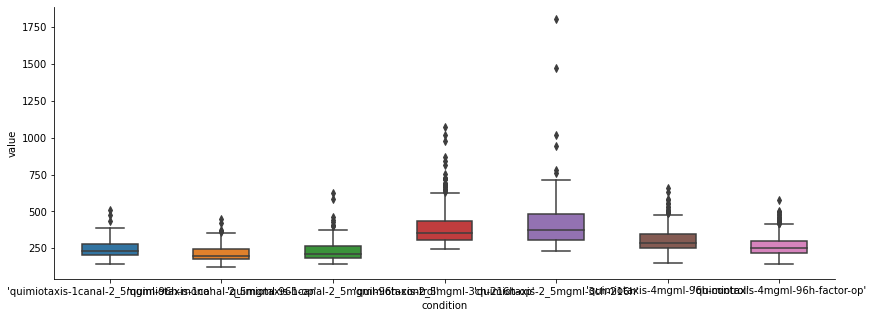

In [61]:
plt.figure(figsize=(14, 5))
sns.boxplot(data=chemotaxis_df, x='condition', y='value', width=0.5)

sns.despine()

In [123]:
chemotaxis_df['group'] = None
chemotaxis_df['name'] = None

chemotaxis_df.loc[chemotaxis_df['condition'].str.contains('4mgml'), 'group'] = 'High density matrix'
chemotaxis_df.loc[chemotaxis_df['condition'].str.contains('216h'), 'group'] = '216 hours'
chemotaxis_df.loc[chemotaxis_df['condition'].str.contains('1canal'), 'group'] = '96 hours'

chemotaxis_df.loc[chemotaxis_df['condition'] == "'quimiotaxis-2_5mgml-3ch-216h'", 'name'] = 'Control'
chemotaxis_df.loc[chemotaxis_df['condition'].str.contains('control'), 'name'] = 'Control'
chemotaxis_df.loc[chemotaxis_df['condition'].str.contains('mono'), 'name'] = 'Monolayer channel'
chemotaxis_df.loc[chemotaxis_df['condition'].str.contains('op'), 'name'] = 'Opposite channel'
chemotaxis_df

,condition,neighborhood,value,group,name
97227,'quimiotaxis-1canal-2_5mgml-96h-mono',10,320.060585,96 hours,Monolayer channel
97228,'quimiotaxis-1canal-2_5mgml-96h-mono',10,321.695698,96 hours,Monolayer channel
97229,'quimiotaxis-1canal-2_5mgml-96h-mono',10,332.132808,96 hours,Monolayer channel
97230,'quimiotaxis-1canal-2_5mgml-96h-mono',10,478.613197,96 hours,Monolayer channel
97231,'quimiotaxis-1canal-2_5mgml-96h-mono',10,231.766930,96 hours,Monolayer channel
...,...,...,...,...,...
372273,'quimiotaxis-4mgml-96h-factor-op',10,289.531524,High density matrix,Opposite channel
372274,'quimiotaxis-4mgml-96h-factor-op',10,190.651027,High density matrix,Opposite channel
372275,'quimiotaxis-4mgml-96h-factor-op',10,414.680683,High density matrix,Opposite channel
372276,'quimiotaxis-4mgml-96h-factor-op',10,221.336721,High density matrix,Opposite channel


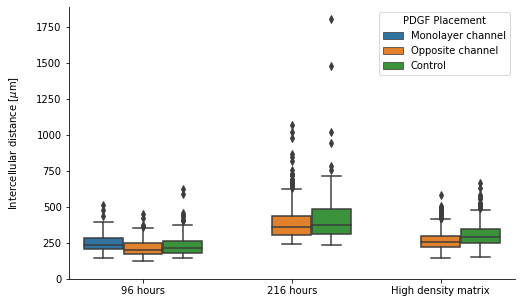

In [124]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=chemotaxis_df, x='group', y='value', hue='name', width=0.8)
plt.ylim(0, None)
plt.xlabel('')
plt.legend(title='PDGF Placement')
plt.ylabel('Intercellular distance [$\mu$m]', labelpad=15)
sns.despine()

plt.savefig('/home/ines/writing/pdgf_paper/hapto_figures/exp-dist.png')

In [49]:
chemotaxis_df['condition'].unique()

array(["'quimiotaxis-1canal-2_5mgml-96h-mono'",
       "'quimiotaxis-1canal-2_5mgml-96h-op'",
       "'quimiotaxis-1canal-2_5mgml-96h-control'",
       "'quimiotaxis-2_5mgml-3ch-216h-op'",
       "'quimiotaxis-2_5mgml-3ch-216h'",
       "'quimiotaxis-4mgml-96h-control'",
       "'quimiotaxis-4mgml-96h-factor-op'"], dtype=object)